# Uplift Modeling

Uplift modeling refers to the set of techniques used to model the impact of an
action or treatment on a customer outcome. While churn modeling lets businesses predict who among their customers is at risk of churning, it provides no indication as to whether or not a customer would react favorably to a follow-up action (e.g. commercial). It would be a waste of time and money to target customers that would not react favorably to a marketing campaign. 

More generally, when speaking of binary treatments (e.g. commercial or no commercial) and a binary outcome variable (Renew subscription or does not renew), we can split customers into 4 different groups:

* the sure things: those customers will renew with and without treatment
* the lost causes: those customers will churn with and without treatment
* the sleeping dogs: those customers who will churn if treated and renew if not treated
* the pursuadables: those customers will renew if treated and churn if not treated

Uplift allows to measure customer reaction to a given commercial. This opens the possibility of targeting customers with the greatest predicted uplift first (as opposed to targetting people with the greatest risk of predicted churn first). By computing the probability of renewal among the treated and untreated, we hope to identify the four profiles listed above, and target persuadables only.

### What you will find in this notebook
One class of uplift models are called Meta-learners. They are named as such because they leverage one or more underlying machine learning model(s) (or learner(s)). In this notebook, we will introduce an S-learner on a toy dataset. This learner leverages a single underlying standard ML model(XGBoost) from the scikit-learn libary. You are welcome to use a different algorithm, experiment with other Meta-learners (T-learner, X-learner or R-learner) or even a different classes of uplift models. Check this [blog](https://johaupt.github.io/causal%20machine%20learning/Uplift_ITE_summary) for an overview of all the methods available. 

We will then show how to evaluate the performance of an uplift model using traditional uplift metrics and graphs.  As we will be dealing with a synthetic dataset, we will be able to identify the four customer profiles profiles (sure things, lost causes, sleeping dogs, persuadable). With those profiles, we can then see how a highest-churn-first targetting policy is performing against a highest-uplift-first policy. Finally, we will run a simulation to show whether our uplift model can beat a churn model in terms of generated revenue.
 

In [71]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib as mpl
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 300
pal = sns.color_palette("tab10")

Populating the interactive namespace from numpy and matplotlib


/home/dataiku/dss/code-envs/python/causalml/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading the data

 This notebook was built to run on a synthetic dataset by [Zhao et al., 2020](https://arxiv.org/abs/2005.03447) publicly available [here](https://zenodo.org/record/3653141#.X-uFoOlKj0t).
* the outcome and treatment variables  are both numerical and binary (0 or 1). The outcome here is an indicator of conversion, where outcome=1 means the customer converted and outcome=0 means the customer churned.
* two assumptions about the treatment hold: <b>unconfoundedness</b> and <b>positivity</b>. Those two strong assumptions hold when the treatment is randomized.


In [72]:
url = 'https://zenodo.org/record/3653141/files/uplift_synthetic_data_100trials.csv?download=1'
df = pd.read_csv(url)

treatment = 'treatment_group_key' 
outcome = 'conversion' 

df[treatment] = df[treatment].map({'control': 0, 'treatment1': 1})
features_no_treatment = df.columns.tolist()[7:] 
features = [treatment] + features_no_treatment

# Data Preprocessing
We'll start with some standard preprocessing to clean the dataset and encode the categorical variable (one-hot representation here).

In [73]:
df = pd.get_dummies(df)

# Descriptive Analysis

The following table gives us the mean and sum of the outcome variable per treatment group. A count also gives us the number of observations per group.

In [74]:
df_gb_results = df.groupby(treatment).agg({outcome:['mean', 'sum', 'count']})
df_gb_results

conversion                
                          mean     sum   count
treatment_group_key                           
0                     0.248528  124264  500000
1                     0.358974  179487  500000

To estimate the Average Treatment Effect (ATE), a simple difference in average outcome per across treatment group.


**⚠ WARNING** This is true because two crucial assumptions hold: <b>unconfoundedness</b> and <b>positivity</b>. Without those two assumptions, taking the difference in average outcomes will produce a biased estimate of the ATE. The same is true regarding estimates coming out of any uplift models. Proper randomization of the treatment should satisfy those two assumptions. 

In [75]:
print('ATE: {}'.format((df_gb_results.loc[1,(outcome, 'mean')]
 - df_gb_results.loc[0,(outcome, 'mean')]).round(4)))

ATE: 0.1104


# Uplift Modeling

### Train & Test Split

In [76]:
train, test = train_test_split(df, test_size=0.2,random_state=42)

X_train = train[features]
y_train = train[outcome]
X_test = test[features]
y_test = test[outcome]

### Training our S-learner

In this section, we implement an S-learner. An S-learner is simply a traditional ML model trained to predict our binary outcome variable as a function of observed features + treatment status.

To actually calculate the uplift for a given data set with this approach, we will need to score our observations twice. Once with treatment = 1 and again with treatment = 0, then subtract these two to get the uplift measure. We will do this on the test set in the next section. 

In [77]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train, eval_metric="auc")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [78]:
X_test_0 = X_test.copy()
X_test_0[treatment] = 0
X_test_1 = X_test.copy()
X_test_1[treatment] = 1

test_w_score = X_test.copy()

test_w_score[outcome] = y_test
test_w_score['uplift_score'] =  model.predict_proba(X_test_1)[:,1] - model.predict_proba(X_test_0)[:,1]


### Training our churn model

We used XGBOost as the underlying model for our S-learner. That model was trained to predict the conversion target as a function of all our observed features and a treatement indicator. We can leverage this same model for our churn model.

In [79]:
test_w_score['proba_churn'] = model.predict_proba(X_test[features])[:,0] 

# Uplift versus Churn 


#### Which profiles do uplift and churn models target?
Let's see how the predictions of an uplift model and of regular churn model correlate with the four customer profiles. Specifically, we would like to measure which of the four profiles tend to be targeted first if we were to compare those following two policies:

1. Targetting customers by descending order of predicted churn probabilities.
2. Targetting customers by descending order by descending order of predicted uplift. 

The beauty of working with a synthetic dataset is that we actually have access to the true probability of conversion with and without treatment. Every observation whose probability of conversion is above 0.5 will be flagged as "converting".

As a result, each customer is assigned a conversion indicator with and without treatment. This is exactly what we need to know to determine which of the four type of customer they fall into.

The true probability columns with and without treatment are named "treatment1_conversion_prob" and "control_conversion_prob".

#### Revenue Simulation

A more tangible way to compare uplift versus churn is to compare both models in terms of revenue. To do so, we will devise a customer revenue simulation where the treatment takes the form of a discount (coupon).

## What profiles do churn and uplift models target?

In [80]:
def predict(col_name, threshold):
    return (test[col_name] >= threshold).astype(int)

def assign_profile(pred_outcome_pre, pred_outcome_post):
    if pred_outcome_pre and pred_outcome_post:
        return 'Sure Thing'
    elif pred_outcome_post and not pred_outcome_pre:
        return 'Persuadable'
    elif not pred_outcome_post and pred_outcome_pre:
        return 'Sleeping Dog'
    else:
        return 'Lost Cause'

In [81]:
threshold_treated = 0.5
threshold_untreated = 0.5

test_w_score['prediction_treated'] = predict('treatment1_conversion_prob',threshold_treated)
test_w_score['prediction_untreated'] = predict('control_conversion_prob', threshold_untreated)

test_w_score['profile'] = list(
    map(
    lambda x,y: assign_profile(x,y),
       test_w_score['prediction_untreated'], 
       test_w_score['prediction_treated']
       )
)

profiles_df = test_w_score[['proba_churn', 'uplift_score', 'profile']]
profiles_df = pd.get_dummies(profiles_df)

Let's rank uplift score and probability of outcome=1 by descending and ascending order, respectively. Then, let's plot the cumulative count of observation by identified profile

Ideally, we want to see that persuadables are targeted first with an uplift model.

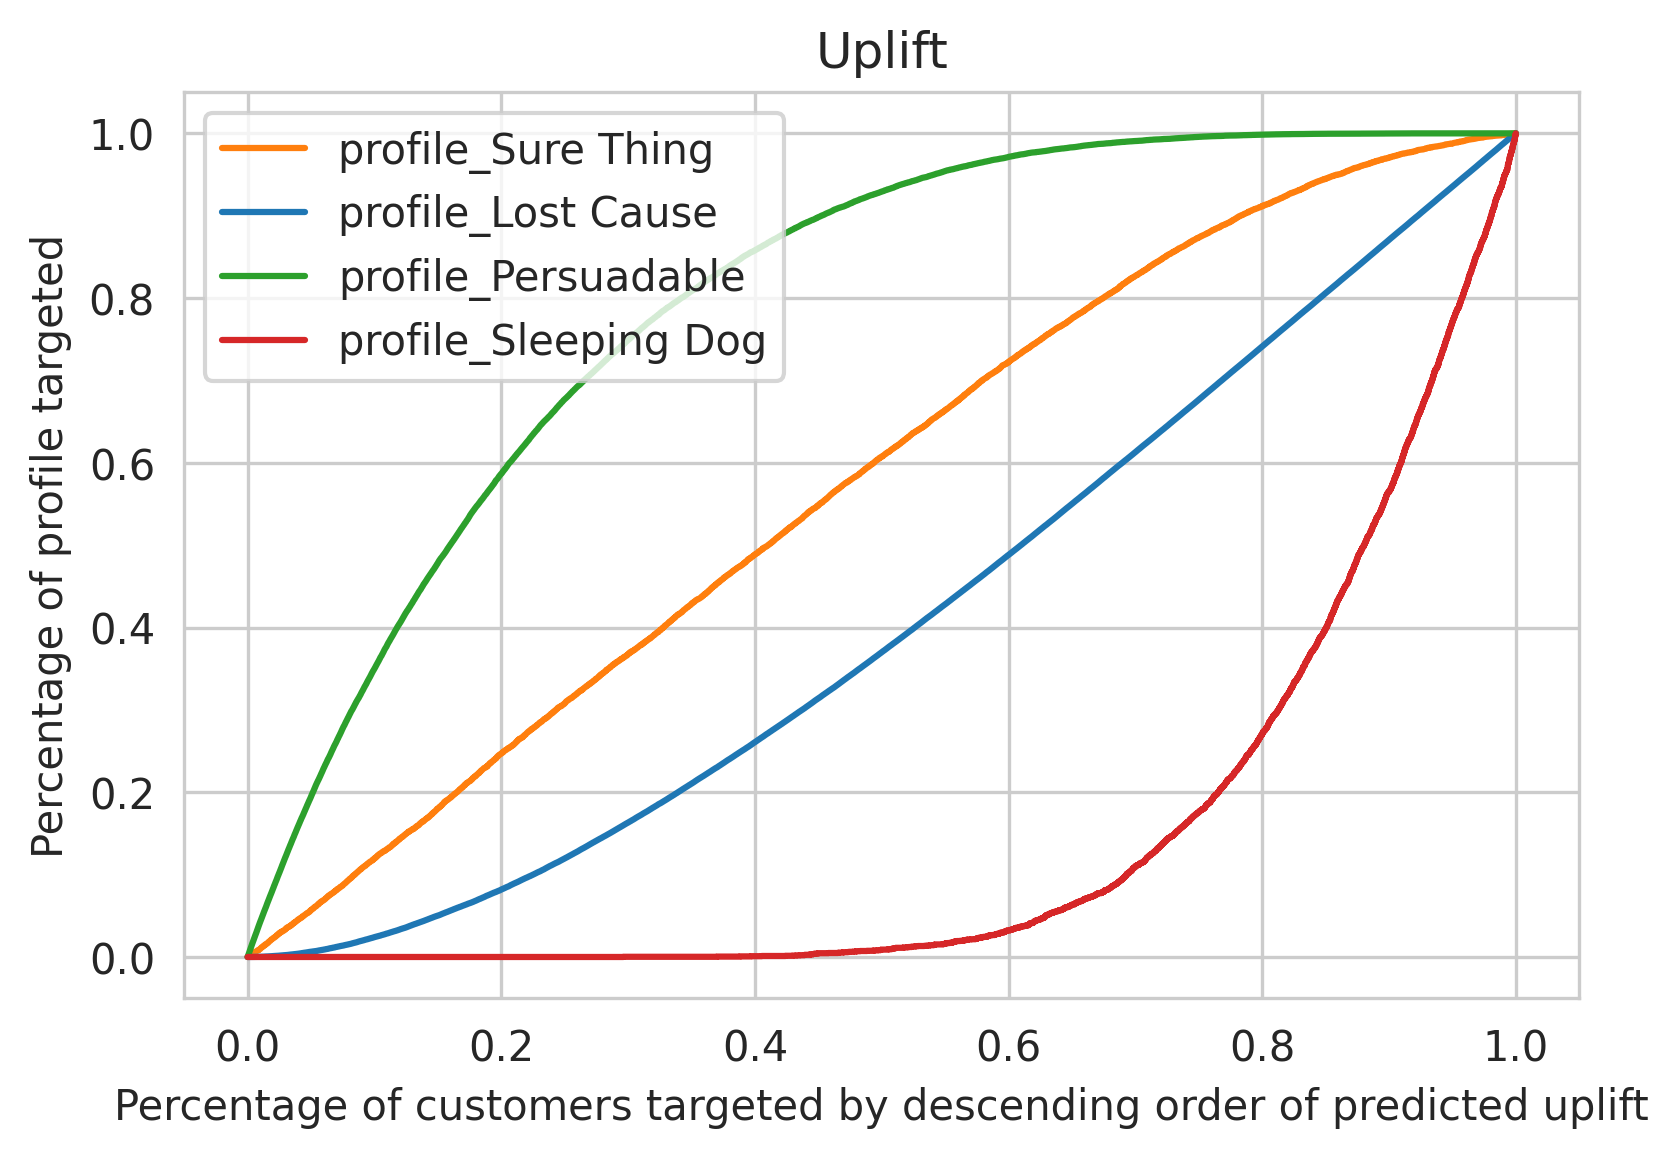

In [82]:
profiles_df.sort_values(by='uplift_score', inplace=True, ascending=False )
uplift_cs = profiles_df[['profile_Sure Thing','profile_Lost Cause',
                         'profile_Persuadable','profile_Sleeping Dog']].cumsum()

for col in uplift_cs.columns:
    # normalize
    uplift_cs[col] = uplift_cs[col]/max(uplift_cs[col])

uplift_cs.index = np.arange(1, len(uplift_cs) + 1)/ len(uplift_cs)
ax = uplift_cs.plot(color=[pal[1], pal[0], pal[2], pal[3]])
ax.set_xlabel("Percentage of customers targeted by descending order of predicted uplift")
ax.set_ylabel("Percentage of profile targeted")
ax.set_title('Uplift')
plt.rcParams["figure.figsize"] = (5,3)
plt.show()

The above graph shows the cumulative count of customers falling in the different profiles as we target them by descending order of predicted uplift. A good uplift model should assign high predicted uplift to persuadables.

Now let's compute a similar graph for our churn model.

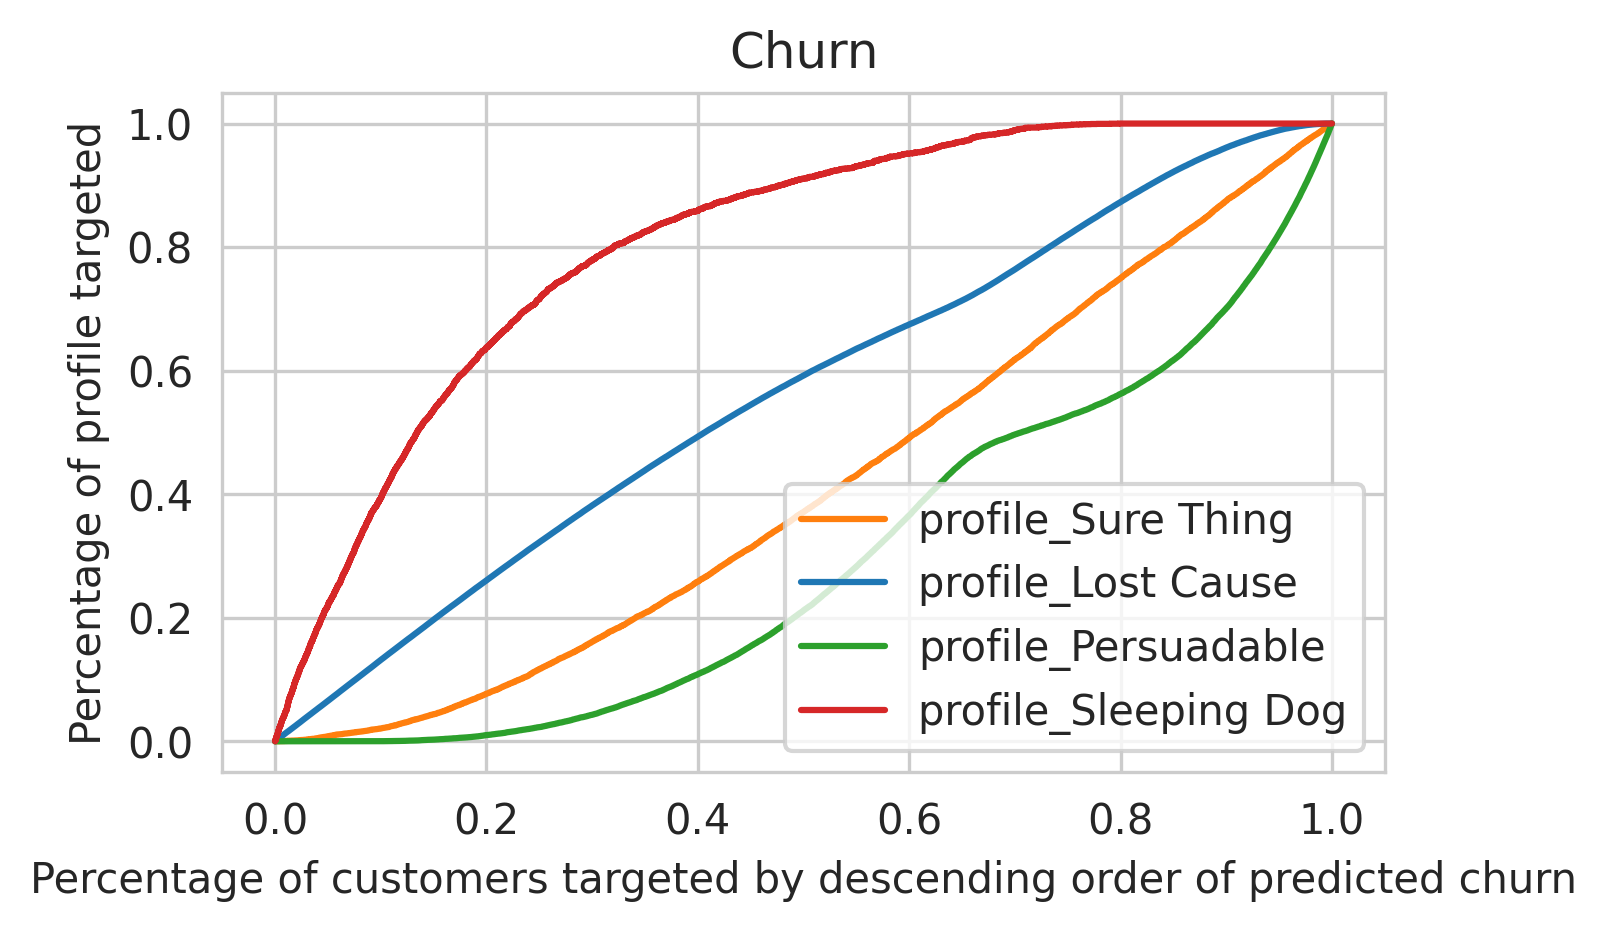

In [83]:

profiles_df.sort_values(by='proba_churn', inplace=True, ascending=False)

outcome_cs = profiles_df[['profile_Sure Thing','profile_Lost Cause',
                         'profile_Persuadable','profile_Sleeping Dog']].cumsum()

for col in outcome_cs.columns:
    # normalize
    outcome_cs[col] = outcome_cs[col]/max(outcome_cs[col])

outcome_cs.index = np.arange(1, len(outcome_cs) + 1)/len(outcome_cs)

ax = outcome_cs.plot(color=[pal[1], pal[0], pal[2], pal[3]])
ax.set_xlabel("Percentage of customers targeted by descending order of predicted churn")
ax.set_ylabel("Percentage of profile targeted")
ax.set_title('Churn')
plt.rcParams["figure.figsize"] = (5,3)
plt.show()

# Uplift versus Churn: Profit Simulation

In this section, we show an example of profit simulation when outcome=1 means that the customer is renewing a $100 subsciption.  

Suppose the treatment is a 10% discount on a subscription.


We then have the two expected revenues:

<p>Expected revenue from a person if TREATED = 
P(conversion|treated)*\$90</p>

<p>Expected revenue from a person if NOT TREATED = 
P(conversion|not treated)*\$100</p>


In [85]:
# get percentiles and dummify profiles
test_w_score['uplift_score_percentile'] = pd.qcut(
    x=test_w_score['uplift_score'],
    q=100, 
    labels=list(reversed(range(1, 101)))
)


test_w_score['proba_churn_percentile'] = pd.qcut(
    x=test_w_score['proba_churn'],
    q=100, 
    labels=list(reversed(range(1, 101)))
)


test_w_score['uplift_score_percentile'] = pd.to_numeric(test_w_score['uplift_score_percentile'] )
test_w_score['proba_churn_percentile'.format(outcome)]  = pd.to_numeric(test_w_score['proba_churn_percentile'])

profiles_df['uplift_score_percentile'] = pd.to_numeric(test_w_score['uplift_score_percentile'])
profiles_df['proba_churn_percentile'] = pd.to_numeric(test_w_score['proba_churn_percentile'])           

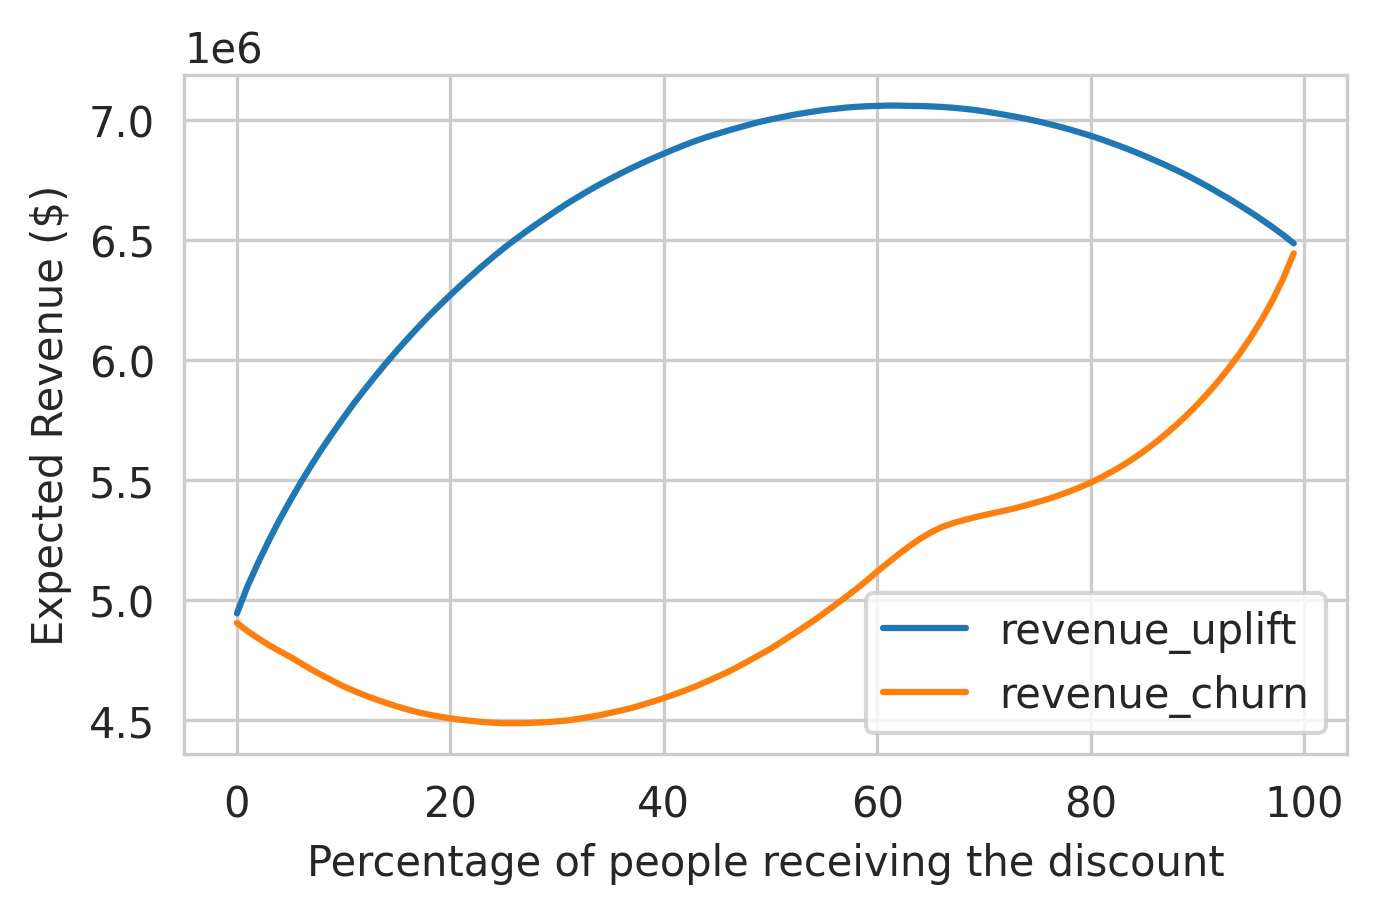

In [87]:
REVENUE_CONVERT_TREATED = 90
REVENUE_CONVERT_NOT_TREATED = 100
TREATMENT_COST = 0


def revenue(treat):  
    proba_pre = test['control_conversion_prob']
    proba_post = test['treatment1_conversion_prob']
    return np.sum(treat*(proba_post*REVENUE_CONVERT_TREATED - TREATMENT_COST) +\
            (1-treat)*proba_pre*REVENUE_CONVERT_NOT_TREATED)


revenue_uplift = list(
    map(lambda x: revenue((test_w_score['uplift_score_percentile'] < x).astype(int)),
        range(1, 101))
       
)

revenue_churn = list(
    map(lambda x: revenue((test_w_score['proba_churn_percentile'] <= x).astype(int)),
        range(1, 101))
)


revenue_results = pd.DataFrame()

revenue_results['revenue_uplift'] = revenue_uplift
revenue_results['revenue_churn'] = revenue_churn


ax = revenue_results.plot()
ax.set_xlabel("Percentage of people receiving the discount")
ax.set_ylabel("Expected Revenue ($)")
plt.show()